In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("TensorFlow version:",tf.__version__)

2025-04-23 14:42:37.969598: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 14:42:37.977077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745399557.985803   16517 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745399557.988372   16517 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745399557.994987   16517 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0


In [4]:
dataset_path = r"/home/ai/Puni_Flora/segmented_Leaf_Dataset"

if not os.path.exists(dataset_path):
    print(f"Dataset directory '{dataset_path}' does not exist. Please provide the correct path.")
else:
    print(f"Dataset directory '{dataset_path}' exists.")

print("\nContents of the dataset directory:")
print(os.listdir(dataset_path))


Dataset directory '/home/ai/Puni_Flora/segmented_Leaf_Dataset' exists.

Contents of the dataset directory:
['Nooni', 'Gasagase', 'Pepper', 'Amruthaballi', 'Lemon', 'Betel', 'Tamarind', 'Bhrami', 'Padri', 'Coriender', 'Ekka', 'Caricature', 'Badipala', 'Onion', 'Thumbe', 'Doddpathre', 'Guava', 'Jasmine', 'Lemongrass', 'Neem', 'Citron lime (herelikai)', 'Bamboo', 'Honge', 'Ganigale', 'Arali', 'kamakasturi', 'Tulsi', 'Chakte', 'Bringaraja', 'Papaya', 'Turmeric', 'Nerale', 'Sampige', 'Mint', 'Palak(Spinach)', 'Parijatha', 'ashoka', 'Castor', 'Tomato', 'Coffee', 'Malabar_Spinach', 'Marigold', 'Taro', 'kepala', 'Raddish', 'Curry', 'Kambajala', 'Seethapala', 'Ganike', 'Kasambruga', 'Aloevera', 'Henna', 'Ginger', 'Hibiscus', 'Amla', 'Insulin']


In [5]:
img_size = 224

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.3,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 11023 images belonging to 56 classes.
Found 2749 images belonging to 56 classes.


In [7]:
base_model = ResNet50(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')

num_classes = train_generator.num_classes

model = Sequential([
    base_model,
    # Additional Conv Layers
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.5),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),
    
    # Global Average Pooling to reduce dimensionality
    GlobalAveragePooling2D(),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Fine-tune the base model by unfreezing some layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# # Load base model without the top classification layers
# base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')

# # Number of classes from the training generator
# num_classes = train_generator.num_classes

# # Create the full model with custom layers
# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),
#     Dense(256, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(128, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.2),
#     Dense(64, activation='relu'),
#     BatchNormalization(),
#     Dense(num_classes, activation='softmax')
# ])

# # Fine-tuning: Unfreeze the last 20 layers of the base model
# for layer in base_model.layers[-20:]:
#     layer.trainable = True

# # Compile the model
# model.compile(
#     optimizer=Adam(learning_rate=1e-4),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Define callbacks
# early_stopping = EarlyStopping(
#     monitor='val_loss', patience=10, restore_best_weights=True
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6
# )

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "best_mobilenetv2.keras",  
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    verbose=1
)


history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]  
)

model.save("Mobilenetv2_model.h5")

/home/ai/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1745399820.904979   17042 service.cc:152] XLA service 0x7ff538004e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745399820.905000   17042 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-04-23 14:47:01.212013: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745399822.672553   17042 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-23 14:47:04.637891: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14709_0', 464 bytes spill stores, 1372 bytes spill loads

2025-04-23 14:47:04.765300: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15564'

  2/345 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - accuracy: 0.0469 - loss: 4.5415   

I0000 00:00:1745399837.738864   17042 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


232/345 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.0571 - loss: 4.1240

2025-04-23 14:47:53.816483: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14709', 8 bytes spill stores, 8 bytes spill loads

2025-04-23 14:47:54.101075: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14709', 136 bytes spill stores, 136 bytes spill loads

2025-04-23 14:47:54.138680: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14709', 12 bytes spill stores, 12 bytes spill loads

2025-04-23 14:47:54.181314: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14709', 5292 bytes spill stores, 5348 bytes spill loads

2025-04-23 14:47:54.229495: I ex

345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.0849 - loss: 3.9644

2025-04-23 14:48:35.901137: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1232', 236 bytes spill stores, 236 bytes spill loads

2025-04-23 14:48:35.969988: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1232_0', 364 bytes spill stores, 1272 bytes spill loads

2025-04-23 14:48:36.087543: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1232', 8 bytes spill stores, 8 bytes spill loads

2025-04-23 14:48:36.197187: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1232', 5356 bytes spill stores, 5412 bytes spill loads

2025-04-23 14:48:36.246790: I e


Epoch 1: val_loss improved from inf to 3.85187, saving model to best_mobilenetv2.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 107s 237ms/step - accuracy: 0.0851 - loss: 3.9630 - val_accuracy: 0.0877 - val_loss: 3.8519 - learning_rate: 1.0000e-04
Epoch 2/25
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.4586 - loss: 2.4927
Epoch 2: val_loss improved from 3.85187 to 3.40790, saving model to best_mobilenetv2.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 63s 183ms/step - accuracy: 0.4588 - loss: 2.4921 - val_accuracy: 0.1892 - val_loss: 3.4079 - learning_rate: 1.0000e-04
Epoch 3/25
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6796 - loss: 1.7704
Epoch 3: val_loss improved from 3.40790 to 2.86894, saving model to best_mobilenetv2.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 64s 184ms/step - accuracy: 0.6797 - loss: 1.7702 - val_accuracy: 0.3507 - val_loss: 2.8689 - learning_rate: 1.0000e-04
Epoch 4/25
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7585 - loss: 1.3758
Epoch 4: val_loss imp

Epoch 23/25
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9573 - loss: 0.1969
Epoch 23: val_loss did not improve from 0.66111
345/345 ━━━━━━━━━━━━━━━━━━━━ 63s 182ms/step - accuracy: 0.9573 - loss: 0.1969 - val_accuracy: 0.8272 - val_loss: 0.7530 - learning_rate: 1.0000e-04
Epoch 24/25
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9609 - loss: 0.1782
Epoch 24: val_loss improved from 0.66111 to 0.60621, saving model to best_mobilenetv2.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 62s 180ms/step - accuracy: 0.9609 - loss: 0.1782 - val_accuracy: 0.8570 - val_loss: 0.6062 - learning_rate: 1.0000e-04
Epoch 25/25
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9596 - loss: 0.1701
Epoch 25: val_loss did not improve from 0.60621
345/345 ━━━━━━━━━━━━━━━━━━━━ 62s 179ms/step - accuracy: 0.9596 - loss: 0.1701 - val_accuracy: 0.8472 - val_loss: 0.6443 - learning_rate: 1.0000e-04


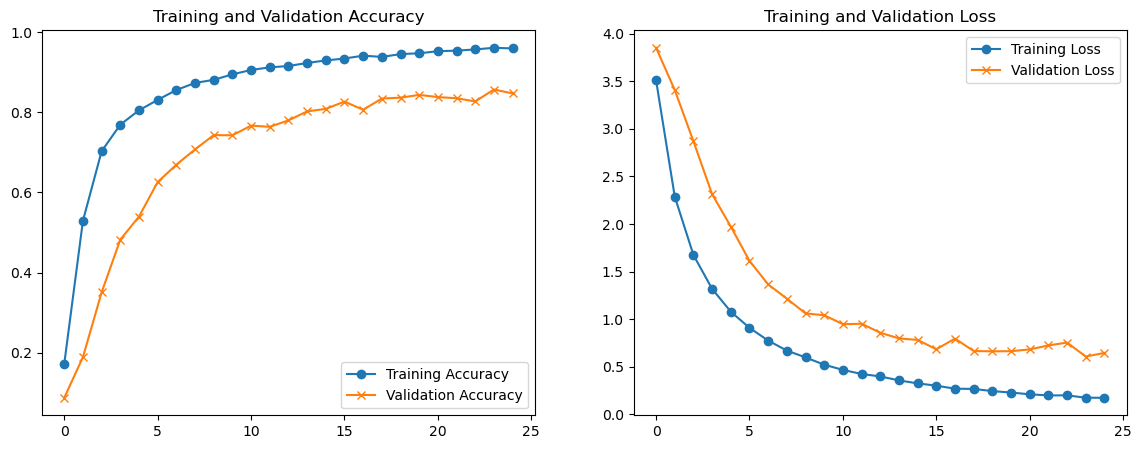

In [9]:
import matplotlib.pyplot as plt

# Extract values from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
lr = history.history.get('lr', None)  # Might be available depending on TF version

epochs_range = range(len(acc))

# Plotting Accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load the trained model
model = tf.keras.models.load_model("/home/ai/Puni_Flora/Mobilenetv2_model.h5")

# Define the class labels (same as used during training)
class_labels = ['Nooni', 'Gasagase', 'Pepper', 'Amruthaballi', 'Lemon', 'Betel', 'Tamarind', 'Bhrami', 'Padri',
                'Coriender', 'Ekka', 'Caricature', 'Badipala', 'Onion', 'Thumbe', 'Doddpathre', 'Guava', 'Jasmine',
                'Lemongrass', 'Neem', 'Citron lime (herelikai)', 'Bamboo', 'Honge', 'Ganigale', 'Arali', 'kamakasturi', 
                'Tulsi', 'Chakte', 'Bringaraja', 'Papaya', 'Turmeric', 'Nerale', 'Sampige', 'Mint', 'Palak(Spinach)', 
                'Parijatha', 'ashoka', 'Castor', 'Tomato', 'Coffee', 'Malabar_Spinach', 'Marigold', 'Taro', 'kepala', 
                'Raddish', 'Curry', 'Kambajala','Seethapala', 'Ganike', 'Kasambruga', 'Aloevera', 'Henna', 'Ginger', 'Hibiscus', 'Amla', 'Insulin']

# Function to preprocess the uploaded image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  # ResNet50 input size is 224x224
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess the image for ResNet50
    return img_array

# Function to make a prediction
def make_prediction(image_path):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions, axis=1)  # Get the class with the highest probability
    predicted_class = class_labels[predicted_class_idx[0]]
    confidence = predictions[0][predicted_class_idx]  # Confidence of the prediction
    return predicted_class, confidence

# Example usage
image_path = r"/home/ai/Puni_Flora/segmented_Leaf_Dataset/Arali/19.jpg"
predicted_class, confidence = make_prediction(image_path)
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: Ganike
Confidence: [0.50818765]


In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load the trained model
model = tf.keras.models.load_model(r"D:\One_Last_Flora\Mobilenetv2_model.h5")

# Define class labels
class_labels = ['Aloevera', 'Amruta_Balli', 'Arali', 'Ashoka', 'Ashwagandha', 'Basale', 'Betel', 'Brahmi', 'Bringaraja', 
                'Caricature', 'Castor', 'Chakte', 'Citron lime (herelikai)', 'Coffee', 'Coriender', 'Curry', 'Doddapatre', 
                'Ekka', 'Ganike', 'Gasagase', 'Gauva', 'Ginger', 'Henna', 'Honge', 'Insulin', 'Jasmine', 'kamakasturi', 
                'Kasambruga', 'kepala', 'Lemon', 'Lemon_grass', 'Malabar_Spinach', 'Marigold', 'Mint', 'Nagadali', 'Neem',
                'Nerale', 'Nithyapushpa', 'Nooni', 'Palak(Spinach)', 'Papaya', 'Parijatha', 'Pepper', 'Raddish', 
                'Raktachandini', 'Sampige', 'Tamarind', 'Thumbe', 'Tulasi', 'Turmeric']

# Segment and preprocess the uploaded image
def segment_and_preprocess(image_path, output_dir="temp_segmented"):
    os.makedirs(output_dir, exist_ok=True)
    file_name = os.path.basename(image_path)
    segmented_path = os.path.join(output_dir, "segmented_" + file_name)

    original = cv2.imread(image_path)
    if original is None:
        raise FileNotFoundError(f"⚠️ Unable to read image: {image_path}")

    resized = cv2.resize(original, (400, 400))
    hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)

    # Green color range for segmentation
    lower_green = np.array([25, 40, 40])
    upper_green = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Morphological operations
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        largest = max(contours, key=cv2.contourArea)
        new_mask = np.zeros_like(mask)
        cv2.drawContours(new_mask, [largest], -1, 255, -1)
        segmented = cv2.bitwise_and(resized, resized, mask=new_mask)
        cv2.imwrite(segmented_path, segmented)
        return segmented_path
    else:
        raise ValueError("❌ No valid leaf contour found.")

# Prepare the image for model prediction
def prepare_for_model(segmented_image_path):
    img = keras_image.load_img(segmented_image_path, target_size=(224, 224))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Perform the final prediction
def make_prediction(image_path):
    try:
        segmented_path = segment_and_preprocess(image_path)
        img_array = prepare_for_model(segmented_path)
        predictions = model.predict(img_array)
        predicted_class_idx = np.argmax(predictions, axis=1)[0]
        predicted_class = class_labels[predicted_class_idx]
        confidence = predictions[0][predicted_class_idx]
        return predicted_class, confidence
    except Exception as e:
        return str(e), 0

# === Example Usage ===
image_path = r"D:\69.jpg"
predicted_class, confidence = make_prediction(image_path)
print(f"🌿 Predicted Class: {predicted_class}")
print(f"📈 Confidence: {confidence:.4f}")
